In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = pd.read_csv(url, usecols=[1])  # Use only the sunspots column
date = pd.read_csv(url, usecols=[0])

# Normalize the data to range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(df.values.reshape(-1, 1)).reshape(-1)

In [4]:
# Function to create sequences of data for RNN input
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]      #Label for a squence is the next element of the sequence
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
SEQ_LENGTH = 36  # Length of the input sequence
X, y = create_sequences(data, SEQ_LENGTH)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [6]:
# Define a custom RNN cell
class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and biases
        self.W_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()  # Call the weight initialization function

    def init_weights(self):
        # Initialize weights using Kaiming uniform initialization
        nn.init.kaiming_uniform_(self.W_ih, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.W_hh, a=np.sqrt(5))
        # Initialize biases with uniform distribution
        nn.init.uniform_(self.b_ih, -0.1, 0.1)
        nn.init.uniform_(self.b_hh, -0.1, 0.1)

    def forward(self, x, hidden):
        # Compute the hidden state using the RNN cell formula
        h_t = torch.tanh(x @ self.W_ih.T + self.b_ih + hidden @ self.W_hh.T + self.b_hh)
        return h_t

In [7]:
# Define the Simple RNN model using the custom RNN cell
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = CustomRNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer

    def forward(self, x):
        h_t = torch.zeros(x.size(0), self.hidden_size)  # Initial hidden state
        hidden_states = []
        for t in range(x.size(1)):
            h_t = self.rnn_cell(x[:, t, :], h_t)
            hidden_states.append(h_t)
        out = self.fc(h_t)  # Output from the final hidden state
        return out, hidden_states


In [8]:
# Hyperparameters
input_size = 1
hidden_size = 50
output_size = 1
num_epochs = 200
learning_rate = 0.001
# Initialize the model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss

In [9]:
# Function for manual optimization of the model parameters
def manual_optimization(model, X, y, learning_rate):
    # Initialize gradients for all model parameters
    grad_W_ih = torch.zeros_like(model.rnn_cell.W_ih)
    grad_W_hh = torch.zeros_like(model.rnn_cell.W_hh)
    grad_b_ih = torch.zeros_like(model.rnn_cell.b_ih)
    grad_b_hh = torch.zeros_like(model.rnn_cell.b_hh)
    grad_fc_w = torch.zeros_like(model.fc.weight)
    grad_fc_b = torch.zeros_like(model.fc.bias)

    model.train()
    output, hidden_states = model(X)

    # Compute the loss
    loss = criterion(output, y)

    # Compute the gradient of the loss with respect to the output
    grad_output = 2 * (output - y) / y.size(0)

    # Gradient for fully connected layer
    grad_fc_w += grad_output.t() @ hidden_states[-1]
    grad_fc_b += grad_output.sum(0)

    # Initialize gradient for the hidden state at the last time step
    grad_h_t_next = grad_output @ model.fc.weight
    hidden_states = torch.stack(hidden_states)  # Convert list to tensor

    # Backpropagation Through Time (BPTT) loop
    for t in reversed(range(X.size(1))):
        grad_h_t = grad_h_t_next * (1 - hidden_states[t] ** 2)  # Gradient through tanh

        # Compute gradients for RNN cell parameters
        grad_W_ih += grad_h_t.t() @ X[:, t, :]
        if t > 0:
            grad_W_hh += grad_h_t.t() @ hidden_states[t-1]
        else:
            grad_W_hh += grad_h_t.t() @ torch.zeros_like(hidden_states[t])
        grad_b_ih += grad_h_t.sum(0)
        grad_b_hh += grad_h_t.sum(0)

        # Update the gradient for the next time step
        grad_h_t_next = grad_h_t @ model.rnn_cell.W_hh

    # Update weights and biases manually
    with torch.no_grad():
        model.rnn_cell.W_ih -= learning_rate * grad_W_ih
        model.rnn_cell.W_hh -= learning_rate * grad_W_hh
        model.rnn_cell.b_ih -= learning_rate * grad_b_ih
        model.rnn_cell.b_hh -= learning_rate * grad_b_hh
        model.fc.weight -= learning_rate * grad_fc_w
        model.fc.bias -= learning_rate * grad_fc_b

    return loss.item()

In [10]:
# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training loop for a specified number of epochs
for epoch in range(num_epochs):
    # Perform manual optimization and get the training loss
    train_loss = manual_optimization(model, X_train.unsqueeze(2), y_train, learning_rate)
    train_losses.append(train_loss)  # Append training loss to the list

    # Switch the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient computation for testing
        # Get the model's predictions on the test set
        test_output, _ = model(X_test.unsqueeze(2))
        # Compute the test loss
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())  # Append test loss to the list

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/200], Train Loss: 0.1269, Test Loss: 0.1232
Epoch [20/200], Train Loss: 0.0863, Test Loss: 0.0846
Epoch [30/200], Train Loss: 0.0618, Test Loss: 0.0613
Epoch [40/200], Train Loss: 0.0470, Test Loss: 0.0471
Epoch [50/200], Train Loss: 0.0380, Test Loss: 0.0385
Epoch [60/200], Train Loss: 0.0326, Test Loss: 0.0332
Epoch [70/200], Train Loss: 0.0292, Test Loss: 0.0300
Epoch [80/200], Train Loss: 0.0272, Test Loss: 0.0280
Epoch [90/200], Train Loss: 0.0259, Test Loss: 0.0267
Epoch [100/200], Train Loss: 0.0250, Test Loss: 0.0258
Epoch [110/200], Train Loss: 0.0244, Test Loss: 0.0253
Epoch [120/200], Train Loss: 0.0240, Test Loss: 0.0249
Epoch [130/200], Train Loss: 0.0237, Test Loss: 0.0246
Epoch [140/200], Train Loss: 0.0235, Test Loss: 0.0243
Epoch [150/200], Train Loss: 0.0233, Test Loss: 0.0241
Epoch [160/200], Train Loss: 0.0231, Test Loss: 0.0240
Epoch [170/200], Train Loss: 0.0230, Test Loss: 0.0238
Epoch [180/200], Train Loss: 0.0228, Test Loss: 0.0237
Epoch [190/200], Tr

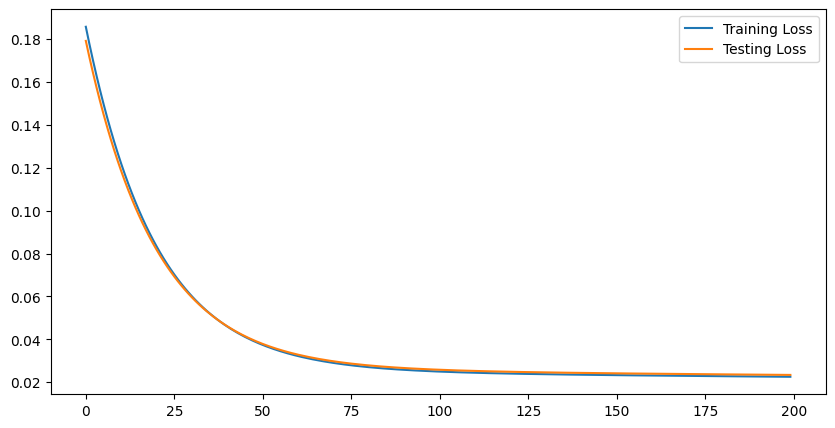

In [11]:
# Plotting the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.show()

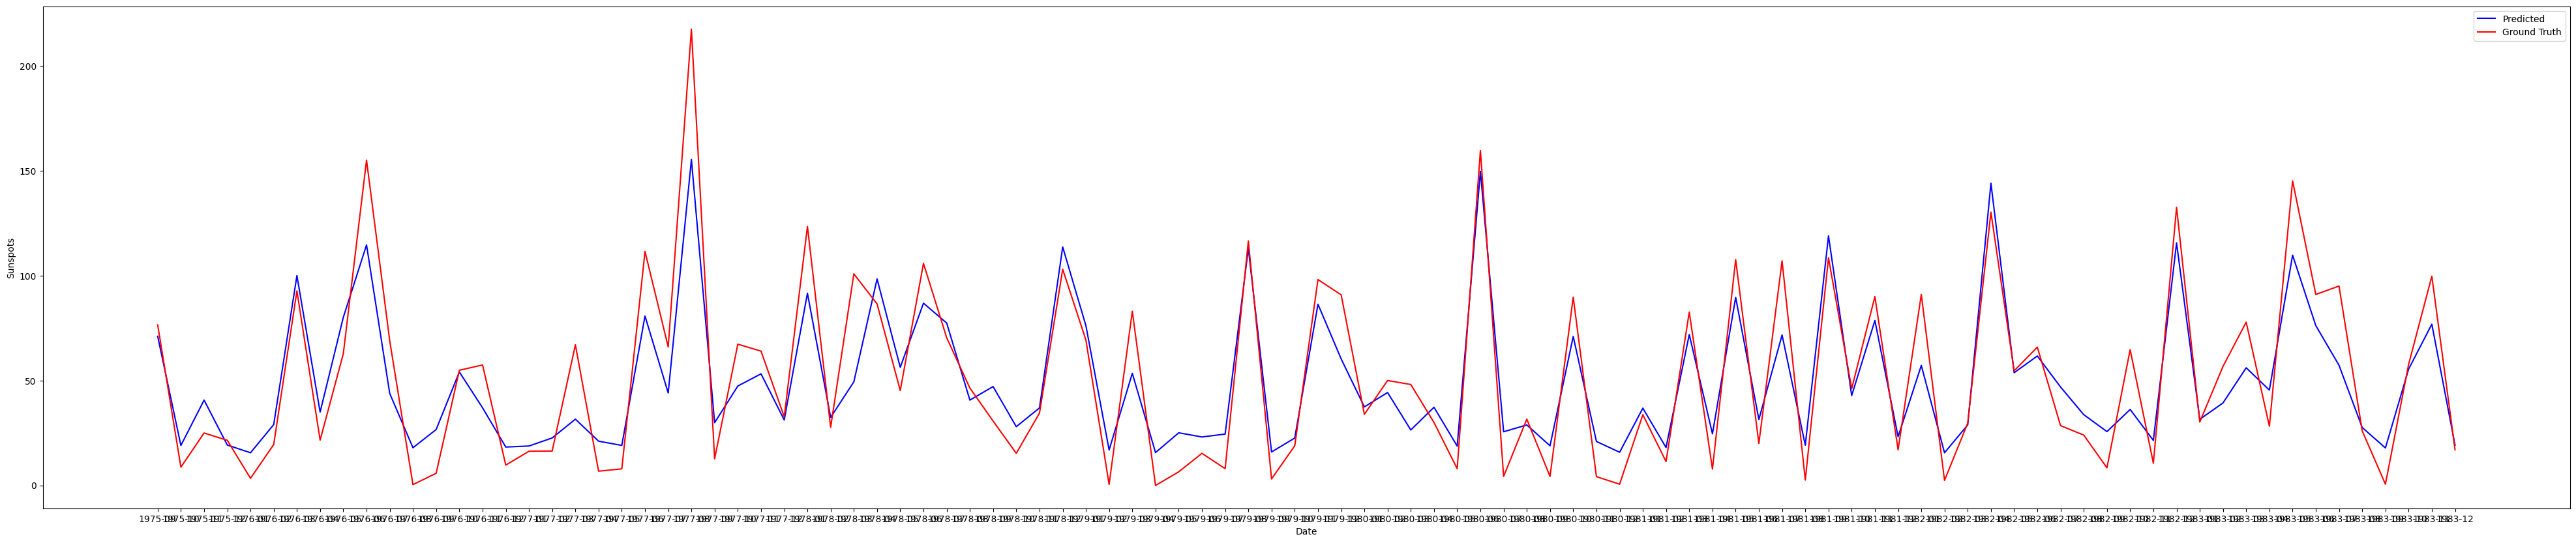

In [21]:
# Plot the predicted vs ground truth
model.eval()
with torch.no_grad():
    predicted, _ = model(X_test.unsqueeze(2))
    predicted = predicted.squeeze().numpy()
    actual = y_test.squeeze().numpy()

# Rescale predictions and actual values back to original scale
predicted_rescaled = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_rescaled = scaler.inverse_transform(actual.reshape(-1, 1))

# Extract the dates corresponding to the test data
test_dates = date.values[SEQ_LENGTH + len(X_train):][:len(predicted_rescaled)].flatten()

# Plot predicted vs actual values with timescale on x-axis
plt.figure(figsize=(50, 10))
plt.plot(test_dates[-100:], predicted_rescaled[-100:], label='Predicted', color='blue')
plt.plot(test_dates[-100:], actual_rescaled[-100:], label='Ground Truth', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.show()